In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt

import os
from PIL import Image
from pathlib import Path
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import tensorflow as tf
import librosa.display

In [2]:
songname = f'../input/gtzan-genre-collection/genres/blues/blues.00000.au'
y, sr = librosa.load(songname, mono=True, duration=2, offset=0)
ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=256, n_fft=512, n_mels=128)
ps = librosa.power_to_db(ps**2)
ps.shape

dataset = []
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 
          'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

for genre, genre_number in genres.items():
    for filename in os.listdir(f'../input/gtzan-genre-collection/genres/{genre}'):
        songname = f'../input/gtzan-genre-collection/genres/{genre}/{filename}'
        for index in range(14):
            y, sr = librosa.load(songname, mono=True, duration=2, offset=index*2)
            ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=256, n_fft=512, n_mels=64)
            ps = librosa.power_to_db(ps**2)
            dataset.append((ps, genre_number))

print(len(dataset))
import random

14000


In [3]:
random.shuffle(dataset)

train = dataset[:10000]
valid = dataset[10000:12000]
test = dataset[12000:]

X_train, Y_train = zip(*train)
X_valid, Y_valid = zip(*valid)
X_test, Y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape((64, 173, 1)) for x in X_train])
X_valid = np.array([x.reshape((64, 173, 1)) for x in X_valid])
X_test = np.array([x.reshape((64, 173, 1)) for x in X_test])

# One-Hot encoding for classes
Y_train = np.array(tf.keras.utils.to_categorical(Y_train, 10))
Y_valid = np.array(tf.keras.utils.to_categorical(Y_valid, 10))
Y_test = np.array(tf.keras.utils.to_categorical(Y_test, 10))

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization

lstm_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.3),
    
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(32),
    BatchNormalization(),
    Dropout(0.3),

    Dense(10, activation='softmax')
])

In [5]:
# Updated GRU Model with Batch Normalization, Dropout, L2 Regularization, and Learning Rate Schedule
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GRU(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GRU(32, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GRU(16),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [6]:
# Updated CNN Model with Batch Normalization, Dropout, L2 Regularization, and Learning Rate Schedule
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 173, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
])


In [18]:
# Compile models
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), loss="categorical_crossentropy", metrics=['accuracy'])
gru_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.02), loss="categorical_crossentropy", metrics=['accuracy'])
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), loss="categorical_crossentropy", metrics=['accuracy'])

In [10]:
# Training models
lstm_history = lstm_model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_valid, Y_valid))

Epoch 1/100
157/157 [==============================] - 16s 29ms/step - loss: 0.4359 - accuracy: 0.8570 - val_loss: 0.9273 - val_accuracy: 0.7285
Epoch 2/100
157/157 [==============================] - 3s 18ms/step - loss: 0.4111 - accuracy: 0.8636 - val_loss: 1.3257 - val_accuracy: 0.6600
Epoch 3/100
157/157 [==============================] - 3s 18ms/step - loss: 0.4026 - accuracy: 0.8710 - val_loss: 1.0329 - val_accuracy: 0.7250
Epoch 4/100
157/157 [==============================] - 3s 17ms/step - loss: 0.4215 - accuracy: 0.8627 - val_loss: 1.1903 - val_accuracy: 0.6795
Epoch 5/100
157/157 [==============================] - 3s 18ms/step - loss: 0.4179 - accuracy: 0.8654 - val_loss: 1.3899 - val_accuracy: 0.6470
Epoch 6/100
157/157 [==============================] - 3s 17ms/step - loss: 0.4023 - accuracy: 0.8675 - val_loss: 1.0212 - val_accuracy: 0.7225
Epoch 7/100
157/157 [==============================] - 3s 17ms/step - loss: 0.3937 - accuracy: 0.8759 - val_loss: 1.1796 - val_accuracy

In [13]:
gru_history = gru_model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_valid, Y_valid))

Epoch 1/100
157/157 [==============================] - 13s 27ms/step - loss: 2.0741 - accuracy: 0.2679 - val_loss: 2.2332 - val_accuracy: 0.2170
Epoch 2/100
157/157 [==============================] - 3s 20ms/step - loss: 2.0371 - accuracy: 0.2877 - val_loss: 2.0712 - val_accuracy: 0.2550
Epoch 3/100
157/157 [==============================] - 3s 20ms/step - loss: 1.9954 - accuracy: 0.3016 - val_loss: 2.3166 - val_accuracy: 0.1890
Epoch 4/100
157/157 [==============================] - 3s 20ms/step - loss: 1.9541 - accuracy: 0.3219 - val_loss: 1.9861 - val_accuracy: 0.2945
Epoch 5/100
157/157 [==============================] - 3s 21ms/step - loss: 1.9121 - accuracy: 0.3379 - val_loss: 1.9756 - val_accuracy: 0.3035
Epoch 6/100
157/157 [==============================] - 3s 20ms/step - loss: 1.8827 - accuracy: 0.3500 - val_loss: 2.7294 - val_accuracy: 0.1850
Epoch 7/100
157/157 [==============================] - 3s 20ms/step - loss: 1.8470 - accuracy: 0.3572 - val_loss: 1.9640 - val_accuracy

In [19]:
cnn_history = cnn_model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data=(X_valid, Y_valid))

Epoch 1/50


2024-11-17 07:30:42.885066: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


157/157 [==============================] - 7s 23ms/step - loss: 0.7363 - accuracy: 0.9283 - val_loss: 1.5099 - val_accuracy: 0.7655
Epoch 2/50
157/157 [==============================] - 3s 20ms/step - loss: 0.7254 - accuracy: 0.9326 - val_loss: 1.4325 - val_accuracy: 0.7740
Epoch 3/50
157/157 [==============================] - 3s 20ms/step - loss: 0.7192 - accuracy: 0.9380 - val_loss: 1.4156 - val_accuracy: 0.7785
Epoch 4/50
157/157 [==============================] - 3s 20ms/step - loss: 0.7295 - accuracy: 0.9352 - val_loss: 1.4734 - val_accuracy: 0.7670
Epoch 5/50
157/157 [==============================] - 3s 20ms/step - loss: 0.7153 - accuracy: 0.9395 - val_loss: 1.3953 - val_accuracy: 0.7695
Epoch 6/50
157/157 [==============================] - 3s 20ms/step - loss: 0.7422 - accuracy: 0.9361 - val_loss: 1.3770 - val_accuracy: 0.7870
Epoch 7/50
157/157 [==============================] - 3s 20ms/step - loss: 0.7106 - accuracy: 0.9437 - val_loss: 1.2493 - val_accuracy: 0.7975
Epoch 8/50

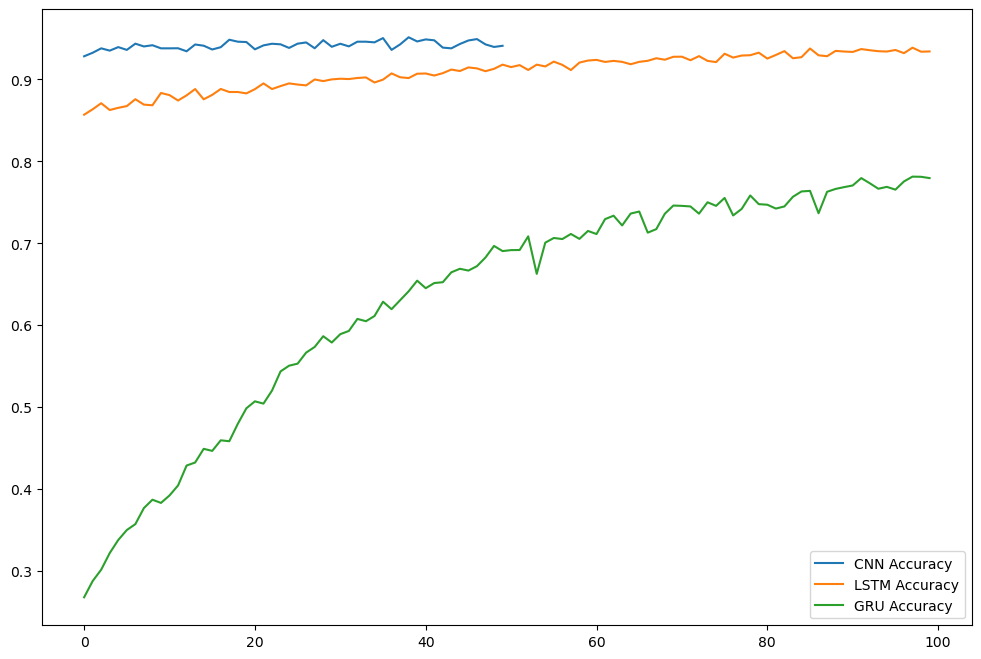

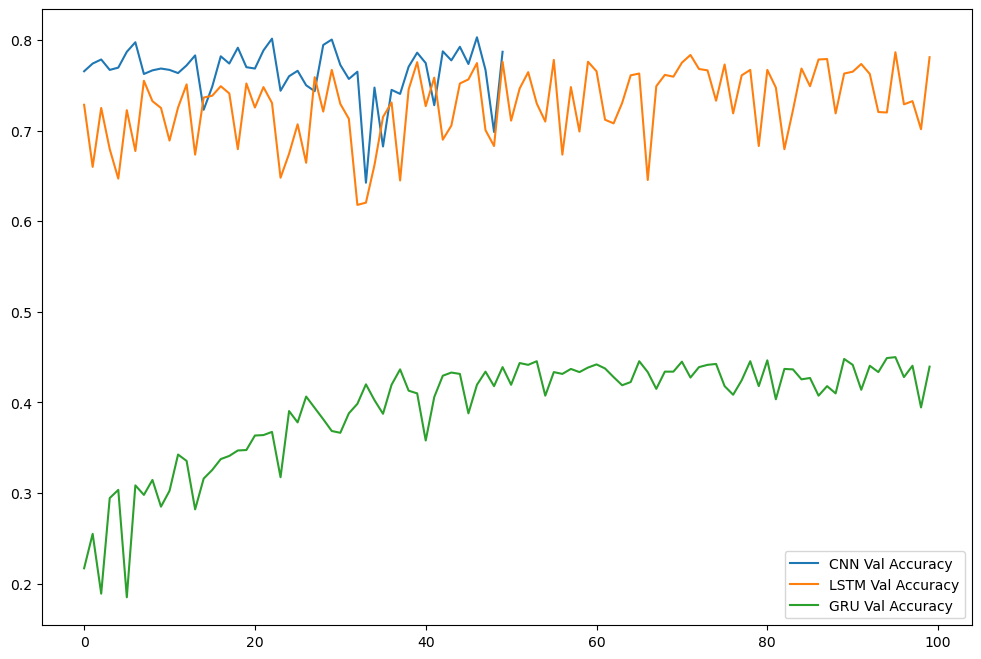

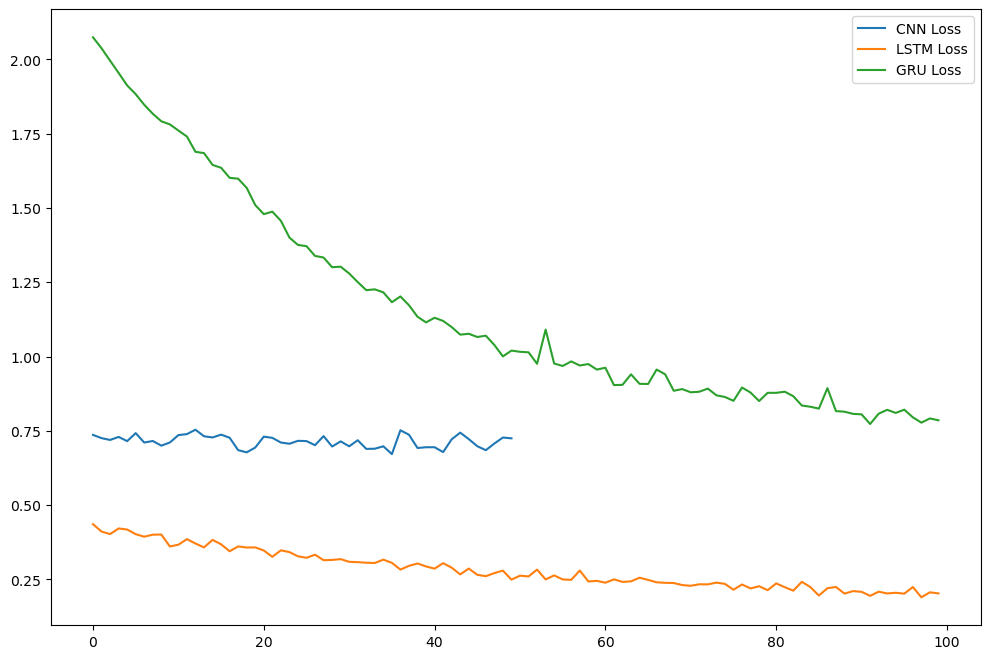

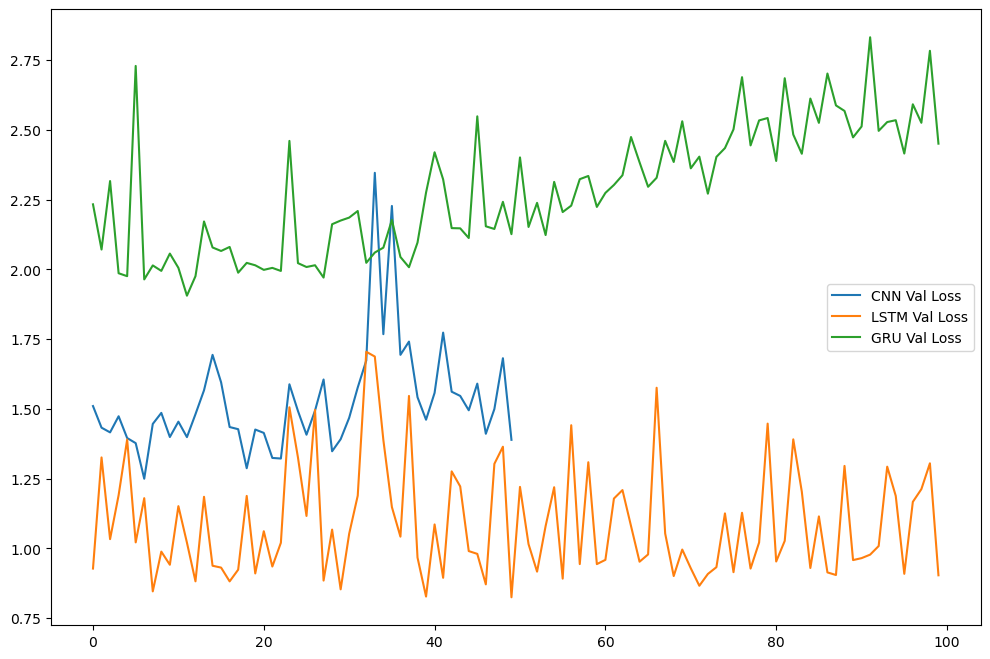

In [20]:
# Plotting Results
plt.figure(figsize=(12, 8))
plt.plot(cnn_history.history['accuracy'])
plt.plot(lstm_history.history['accuracy'])
plt.plot(gru_history.history['accuracy'])
plt.legend(['CNN Accuracy', 'LSTM Accuracy', 'GRU Accuracy'])
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(cnn_history.history['val_accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.plot(gru_history.history['val_accuracy'])
plt.legend(['CNN Val Accuracy', 'LSTM Val Accuracy', 'GRU Val Accuracy'])
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(cnn_history.history['loss'])
plt.plot(lstm_history.history['loss'])
plt.plot(gru_history.history['loss'])
plt.legend(['CNN Loss', 'LSTM Loss', 'GRU Loss'])
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(cnn_history.history['val_loss'])
plt.plot(lstm_history.history['val_loss'])
plt.plot(gru_history.history['val_loss'])
plt.legend(['CNN Val Loss', 'LSTM Val Loss', 'GRU Val Loss'])
plt.show()


In [21]:
# Evaluate Models on Test Data
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test, Y_test, verbose=2)
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test, Y_test, verbose=2)
gru_test_loss, gru_test_acc = gru_model.evaluate(X_test, Y_test, verbose=2)

print('CNN Test Accuracy:', cnn_test_acc)
print('LSTM Test Accuracy:', lstm_test_acc)
print('GRU Test Accuracy:', gru_test_acc)


63/63 - 0s - loss: 1.5558 - accuracy: 0.7815 - 314ms/epoch - 5ms/step
63/63 - 4s - loss: 0.9979 - accuracy: 0.7720 - 4s/epoch - 67ms/step
63/63 - 3s - loss: 2.5744 - accuracy: 0.4380 - 3s/epoch - 41ms/step
CNN Test Accuracy: 0.781499981880188
LSTM Test Accuracy: 0.7720000147819519
GRU Test Accuracy: 0.43799999356269836


In [22]:
# Load and preprocess the input track
input_songname = '/kaggle/input/gtzan-genre-collection/genres/hiphop/hiphop.00011.au'  # Provide the path to the input audio track


# Load the input track and preprocess it
input_y, sr = librosa.load(input_songname, mono=True, duration=2, offset=0)
input_ps = librosa.feature.melspectrogram(y=input_y, sr=sr, hop_length=256, n_fft=512, n_mels=64)
input_ps = librosa.power_to_db(input_ps**2)

# Reshape the input_ps to match the input shape expected by the CNN model (None, 64, 173, 1)
# You need to make sure the number of time frames (173) matches the CNN model's input shape
input_ps = input_ps[:, :173]  # Keep only the first 173 time frames
input_ps = input_ps.reshape(1, input_ps.shape[0], input_ps.shape[1], 1)

# Make predictions using the ensemble model
ensemble_predictions = np.argmax(cnn_model.predict(input_ps) + lstm_model.predict(input_ps), axis=1)

# Map the predicted class label to the corresponding music genre
reverse_genres = {v: k for k, v in genres.items()}
predicted_genre = reverse_genres[ensemble_predictions[0]]

print(f"The input track belongs to the genre: {predicted_genre}")


1/1 [==============================] - 2s 2s/step
The input track belongs to the genre: classical


In [23]:
# Make predictions on the test set
cnn_predictions = cnn_model.predict(X_test)
lstm_predictions = lstm_model.predict(X_test)
gru_predictions = gru_model.predict(X_test)

# Combine predictions using majority voting
ensemble_predictions = np.argmax(cnn_predictions + lstm_predictions, axis=1)

# Calculate accuracy of the ensemble model
ensemble_accuracy = np.mean(ensemble_predictions == np.argmax(Y_test, axis=1))
print(f"Ensemble Model Accuracy: {ensemble_accuracy}")

63/63 [==============================] - 2s 7ms/step
Ensemble Model Accuracy: 0.836
